[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/LinearRegression.ipynb)


# Linear Regression
Lets define a linear regression class, with the usual fit and predict methods.

In [11]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

In [12]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass
    
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        #alternatively: self.w = np.linalg.inv(x.T @ x)@x.T@y
        self.w = np.linalg.lstsq(x, y)[0]
        return self
    
    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh


fit this linear model to toy data with $x \in \Re^1$ + a bias parameter

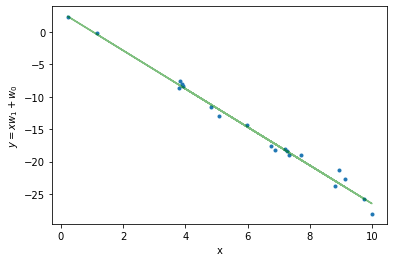

In [13]:
N = 20
x = np.random.rand(N) * 10
y = -3*x + 3 + 1*np.random.randn(N)
model = LinearRegression()
yh = model.fit(x,y).predict(x)
plt.plot(x, y, '.')
plt.plot(x, yh, 'g-', alpha=.5)
plt.xlabel('x')
plt.ylabel(r'$y=xw_1 + w_0$')
plt.show()

## Weight Space
Next, for the same problem we plot *cost* as a function of model parameters (weights), and show the correspondence between the different weights having different costs and their fit. 

The `plot_contour` is a helper function we use for plotting the cost function moving forward. This gives a contour plot of `f` as a functions of two parameters that range between 

In [14]:
import itertools
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

Now let's define the cost function for linear regression example above, and visualize the cost and the fit of various models (parameters).

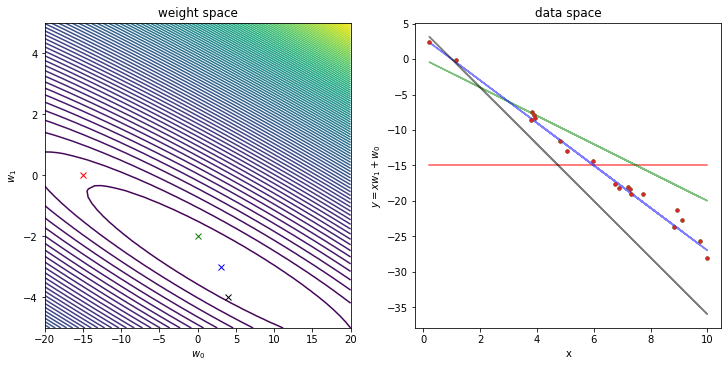

In [15]:
cost = lambda w: .5*np.mean((w[0] + w[1]*x - y)**2)
model_list = [(-15,0), (0,-2), (3,-3), (4,-4)]
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(10, 5))
plot_contour(cost, [-20,20], [-5,5], 50, axes[0])
colors = ['r','g', 'b', 'k']
for i, w in enumerate(model_list):
    axes[0].plot(w[0], w[1], 'x'+colors[i])
    axes[1].plot(x, y, '.')
    axes[1].plot(x, w[0]+w[1]*x, '-'+colors[i], alpha=.5)
axes[0].set_xlabel(r'$w_0$')
axes[0].set_ylabel(r'$w_1$')
axes[0].set_title('weight space')
axes[1].set_xlabel('x')
axes[1].set_ylabel(r'$y=xw_1 + w_0$')
axes[1].set_title('data space')
plt.show()

In the plot above you see that the blue fit is better that others, it also has the lowest cost. 

# Nonlinear basis functions
Consider the toy dataset below. It is obvious that our attempt to model $y$ as a linear function of $x$ would produce a bad fit.
Let's try!

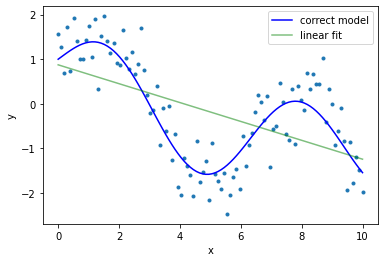

In [16]:
N = 100
x = np.linspace(0,10, N)
yt = np.sin(x) + np.cos(x**.5)
y = yt + .5*np.random.randn(N)
yh = model.fit(x,y).predict(x)
plt.plot(x, y, '.')
plt.plot(x, yt, 'b-', label='correct model')
plt.plot(x, yh, 'g-', alpha=.5, label='linear fit')
plt.xlabel('x')
plt.ylabel(r'y')
plt.legend()
plt.show()

one way around this is to create new features, and create a better fit using them. Right now we only have a single feature 'x' and we have a poor fit.
We can create new features out of existing ones. In this case, we create features that are Gaussian-like functions of 'x', where each feature has a different mean. 
These are called non-linear bases, because each new feature is a non-linear function of the existing one.
Note that there are many other features that you can build to better fit this data. Below, we build ten such features with 10 different mean values.
By doing this our new design matrix (called `Phi` below) had 10 features (+1 intercept that is added in the `LinearRegression` class).
Below, let's plot these non-linear bases.

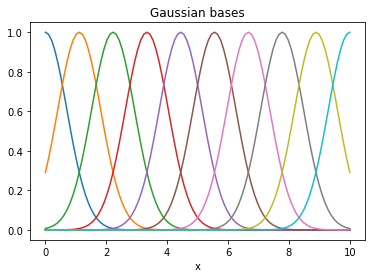

In [17]:
D=10
gaussian = lambda x,mu,sigma: np.exp(-((x-mu)/sigma)**2)
mu = np.linspace(0,10,D)
phi = gaussian(x[:,None], mu[None,:],1)
for d in range(D):
    plt.plot(x, phi[:,d], '-')
plt.xlabel('x')
plt.title('Gaussian bases')
plt.show()

Now we predict `y` using `phi` as input features rather than `x`:

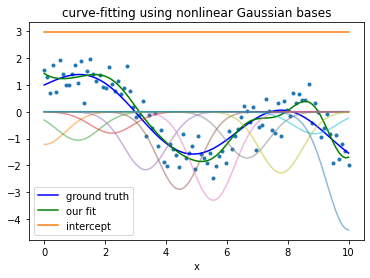

In [19]:
yh = model.fit(phi,y).predict(phi)
fig, ax = plt.subplots()
plt.plot(x, y, '.')
plt.plot(x, yt, 'b-', label='ground truth')
plt.plot(x, yh, 'g-', label='our fit')
for d in range(D):
    plt.plot(x, model.w[d]*phi[:,d], '-', alpha=.5)
plt.plot(x, model.w[-1]*np.ones_like(y), label='intercept')
plt.legend()
plt.xlabel('x')
plt.title('curve-fitting using nonlinear Gaussian bases')
plt.show()

Since our fit is a linear combination of these bases, you can see that by suming these weighted bases and the intercept, we recover our fit (green curve). Note that here we could plot all features and our prediction for $D=10$ only because all of features are functions of $x$. In general, when we have D features, we need to use a $D+1$ dimensional plot (+1 is for the label $y$). 

We can simply replace the bases above with sigmoid bases and fit the data again.

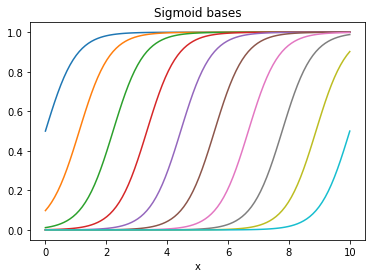

In [26]:
sigmoid = lambda x,mu, s: 1/(1 + np.exp(-(x - mu)/s))
mu = np.linspace(0,10,D)
phi = sigmoid(x[:,None], mu[None,:], .5)
for d in range(D):
    plt.plot(x, phi[:,d], '-')
plt.xlabel('x')
plt.title('Sigmoid bases')
plt.show()

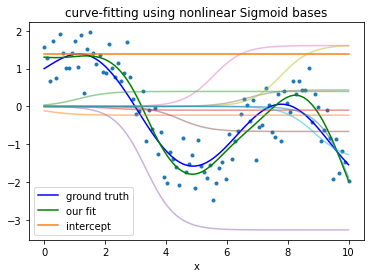

In [28]:
yh = model.fit(phi,y).predict(phi)
fig, ax = plt.subplots()
plt.plot(x, y, '.')
plt.plot(x, yt, 'b-', label='ground truth')
plt.plot(x, yh, 'g-', label='our fit')
for d in range(D):
    plt.plot(x, model.w[d]*phi[:,d], '-', alpha=.5)
plt.plot(x, model.w[-1]*np.ones_like(y), label='intercept')
plt.legend()
plt.xlabel('x')
plt.title('curve-fitting using nonlinear Sigmoid bases')
plt.show()